In [253]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [11]:
%reload_ext autoreload
%autoreload 2

# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW9

---
__Name:__  *Jason Sanchez*   
__Class:__ MIDS w261 (Section *Fall 2016 Group 2*)     
__Email:__  *jason.sanchez*@iSchool.Berkeley.edu     
__Due Time:__ HW9 is due on Tuesday 11/15/2016. 

# Table of Contents <a name="TOC"></a> 

1.  [HW Instructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
1.  [HW Introduction](#1)   
2.  [HW References](#2)
3.  [HW  Problems](#3)   
    1.0.  [HW9.0](#1.0)   
    1.0.  [HW9.1](#1.1)   
    1.2.  [HW9.2](#1.2)   
    1.3.  [HW9.3](#1.3)    
    1.4.  [HW9.4](#1.4)    
    1.5.  [HW9.5](#1.5)    
    1.5.  [HW9.6](#1.6)    
   

<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)

MIDS UC Berkeley, Machine Learning at Scale
DATSCIW261 ASSIGNMENT #9

Version 2016-11-01 

### INSTRUCTIONS for SUBMISSIONS
Please use the following form for HW submission:

https://docs.google.com/forms/d/1ZOr9RnIe_A06AcZDB6K1mJN4vrLeSmS2PD6Xm3eOiis/viewform?usp=send_form 


### IMPORTANT

HW9 can be completed locally on your computer for most part but will require a cluster of computers for the bigger wikipedia dataset.

### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* See async and live lectures for this week
* Data-intensive text processing with MapReduce. San Rafael, CA: Morgan & Claypool Publishers. Chapter 5. 



<a name="3">
# HW Problems
[Back to Table of Contents](#TOC)

<h2 style="color:darkblue">HW 9 Dataset</h2>

Note that all referenced files are in the enclosing directory. [Checkout the Data subdirectory on Dropbox](https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0) or the AWS S3 buckets (details contained each question). 

## 3.  HW9.0  Short answer questions<a name="1.0"></a>
[Back to Table of Contents](#TOC)

__ What is PageRank and what is it used for in the context of web search?__ 
PageRank is an algorithm used to score pages based on the PageRank scores of inbound links. These scores can be used as a component in ranking pages returned by search engines.

<hr>

__ What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to compute the Steady State Distibution? __ 
Stochasticity to resolve dangling edges and teleportation so that any node can be reached by any other node.


<hr>

__ OPTIONAL: In topic-specific pagerank, how can we ensure that the irreducible property is satifsied? (HINT: see HW9.4) __ 
Drop nodes that have no inlinks.


<hr>


In [12]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib.pyplot as plt
from numpy.random import choice, rand
from collections import defaultdict
from pprint import pprint
import pandas as pd
import numpy as np
import mrjob

<h2 style="color:darkgreen"> HW 9.1 Implementation </h2>

## 3.  HW9.1  MRJob implementation of basic PageRank <a name="1.1"></a>
[Back to Table of Contents](#TOC)

Write a basic MRJob implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input (as explored in HW 7).

Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1).


[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page, chooses the next page to which it will move by clicking at random, with probability d,one of the hyperlinks in the current page. This probability is represented by a so-called *damping factor* d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer jumps to any web page in the network. If a page is a dangling end, meaning it has no outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform distribution and “teleports” to that page]

As you build your code, use the data located here :

In the Data Subfolder for HW7 on Dropbox (same dataset as HW7) with the same file name. 
> Dropbox: https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0

Or on Amazon: 

> s3://ucb-mids-mls-networks/PageRank-test.txt

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck your work with the true result, displayed in the first image in the [Wikipedia article](https://en.wikipedia.org/wiki/PageRank)
and here for reference are the corresponding PageRank probabilities:
<pre>

A, 0.033
B, 0.384
C, 0.343
D, 0.039
E, 0.081
F, 0.039
G, 0.016
H, 0.016
I, 0.016
J, 0.016
K, 0.016

</pre>

### Here are some simple in memory implementations of PageRank

The point of these implementations was for me to deeply understand PageRank.

In [229]:
# Here are the correct PR values to compare each implementation against
true_values = [ 0.03278149,  0.38440095,  0.34291029,  0.03908709,  0.08088569,
                0.03908709,  0.01616948,  0.01616948,  0.01616948,  0.01616948,
                0.01616948]

### Random Walk

#### Perform a simple random walk with adjacency lists and track which pages are visited.

Page visit counts: 
{'A': 1400,
 'B': 15355,
 'C': 13645,
 'D': 1562,
 'E': 3261,
 'F': 1586,
 'G': 625,
 'H': 622,
 'I': 648,
 'J': 630,
 'K': 667}

PageRank for page A: 0.034999
PageRank for page C: 0.341116
PageRank for page B: 0.383865
PageRank for page E: 0.081523
PageRank for page D: 0.039049
PageRank for page G: 0.015625
PageRank for page F: 0.039649
PageRank for page I: 0.016200
PageRank for page H: 0.015550
PageRank for page K: 0.016675
PageRank for page J: 0.015750

Time taken:
CPU times: user 254 ms, sys: 6.12 ms, total: 260 ms
Wall time: 257 ms


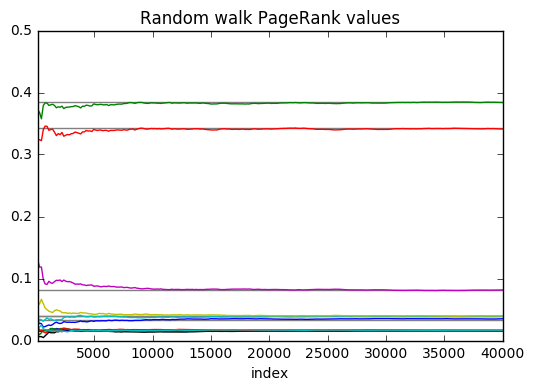

In [242]:
%%time
pages = {"B":["C"],
         "C":["B"],
         "D":["A","B"],
         "E":["B","D","F"],
         "F":["B","E"],
         "G":["B","E"],
         "H":["B","E"],
         "I":["B","E"],
         "J":["E"],
         "K":["E"]}

teleport = .15
iterations = 40001
all_nodes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K"]

iterations_to_plot = 250
page_visits = defaultdict(int)
default_val = 1.0/len(all_nodes)
current_page = pages.keys()[0]
mod = iterations//iterations_to_plot
all_page_visits = []

for i in xrange(iterations):
    if rand() < teleport:
        possible_pages = all_nodes
    else:
        possible_pages = pages.get(current_page, all_nodes)
    current_page = choice(possible_pages)
    page_visits[current_page] += 1
    if i%mod == 0:
        dict_to_save = dict(page_visits)
        dict_to_save["index"] = i
        all_page_visits.append(dict_to_save)
    
print("Page visit counts: ")
pprint(dict(page_visits))
print()

total = 0.0
for page, counts in page_visits.items():
    total += counts
    
for page, counts in page_visits.items():
    print("PageRank for page %s: %f" % (page, counts/total))
    
print("\n", "Time taken:", sep="")
data = pd.DataFrame(all_page_visits[1:])
data.index = data.pop("index")
normalized_data = data.div(data.sum(axis=1), axis=0)
normalized_data.plot(legend=False)
plt.ylim(0,.5)
plt.hlines(true_values,0,iterations-1, colors="grey")
plt.title("Random walk PageRank values");

### Power Iteration

Here is a simple implementatin of the power iteration method of solving for the PageRank scores.

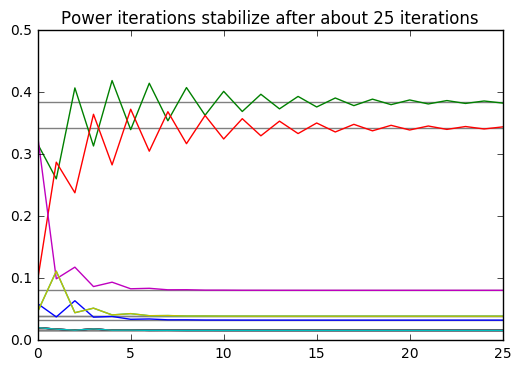

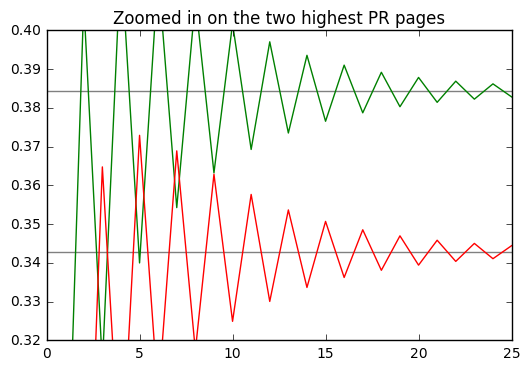

In [246]:
iterations = 26
d = .85

thd = 1/3.0
fll = 1/11.0
T = np.array( [[ fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll],
               [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0.5,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  thd,  0. ,  thd,  0. ,  thd,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

teleport = np.ones(T.shape)/T.shape[0]
T = d*T + (1-d)*teleport

stable = np.ones(T.shape[0])/T.shape[0]

all_stables = []

for i in xrange(iterations):
    stable = stable.dot(T)
    all_stables.append(stable)

plt.plot(all_stables)
plt.hlines(true_values,0,iterations-1, colors="grey")
plt.title("Power iterations stabilize after about 25 iterations")
plt.ylim(0,.5)
plt.show()

plt.plot(all_stables)
plt.hlines(true_values,0,iterations-1, colors="grey")
plt.title("Zoomed in on the two highest PR pages")
plt.ylim(.32, .4);

### T^2 Power Iteration

This is a new method. Instead of using the transition matrix, we use T^2. We find the oscillations disappear and results converge much faster.

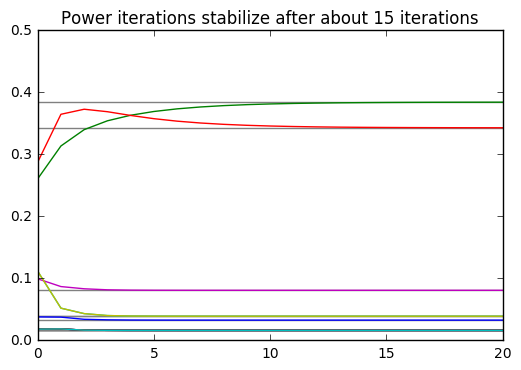

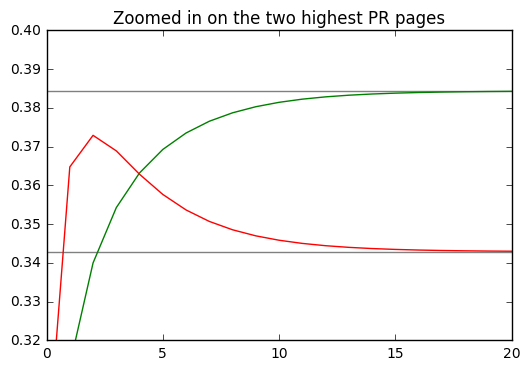

In [271]:
iterations = 21
d = .85

thd = 1/3.0
fll = 1/11.0
T = np.array( [[ fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll],
               [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0.5,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  thd,  0. ,  thd,  0. ,  thd,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

teleport = np.ones(T.shape)/T.shape[0]
T = d*T + (1-d)*teleport
T = T.dot(T) # This is what changed

stable = np.ones(T.shape[0])/T.shape[0]

all_stables = []

for i in xrange(iterations):
    stable = stable.dot(T)
    all_stables.append(stable)

plt.plot(all_stables)
plt.hlines(true_values,0,iterations-1, colors="grey")
plt.title("Power iterations stabilize after about 15 iterations")
plt.ylim(0,.5)
plt.show()

plt.plot(all_stables)
plt.hlines(true_values,0,iterations-1, colors="grey")
plt.title("Zoomed in on the two highest PR pages")
plt.ylim(.32, .4);

### Compounding Power Iteration

This is a new algorithm. Instead of multiplying the current result by the transition matrix, we can multiply the transition matrix by itself and continually multiply the new result by itself.

This means that what we are really calculating each step is $T \rightarrow T^2 \rightarrow T^4 \rightarrow T^8 \rightarrow T^{16} \rightarrow T^{32}$. This results in the fastest convergence of any algorithm seen so far with the correct rank order being found after two iterations and the exact solution being found after five iterations. 

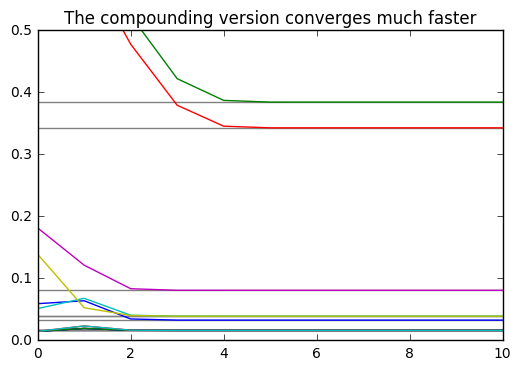

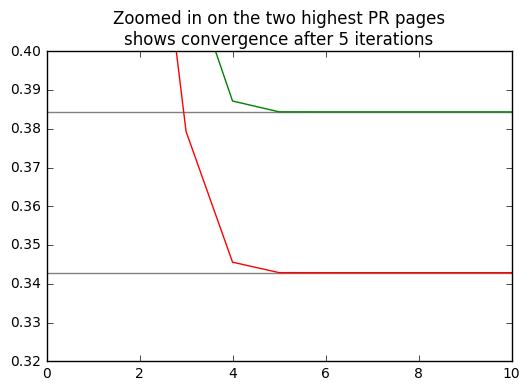

In [267]:
iterations = 11
d = .85

thd = 1/3.0
fll = 1/11.0
T = np.array( [[ fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll,  fll],
               [ 0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0.5,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  thd,  0. ,  thd,  0. ,  thd,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
               [ 0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

teleport = np.ones(T.shape)/T.shape[0]
T = d*T + (1-d)*teleport

all_stables = []

for i in xrange(iterations):
    T = T.dot(T)
    all_stables.append(T.diagonal())
    
plt.plot(all_stables);
plt.hlines(true_values,0,iterations-1, colors="grey")
plt.title("The compounding version converges much faster")
plt.ylim(0,.5)
plt.show()

plt.plot(all_stables)
plt.hlines(true_values,0,iterations-1, colors="grey")
plt.title("Zoomed in on the two highest PR pages\nshows convergence after 5 iterations")
plt.ylim(.32, .4);

print()

My suspicion is that a four iteration solution is possible with some more thinking. But because this method is not scalable, it makes sense to move onto a better solution.

In the lectures, there was a statement that was repeated over and over again. "The most efficient, distributed PageRank algorithm must be composed of at least two MapReduce steps." This is unfortunate because it would mean the entire dataset would have to be copied twice for each step.

I decided to figure out how to do it in one step.

### First attempt

#### Here is a one-stage solution to the problem that uses a single reducer

Main thoughts when creating it: 
* Use the number of nodes as an input argument.
* Continually track the Total PageRank in the system, the amount of PageRank to distribute, and the number of nodes in the system using the order inversion pattern. 
* When a dangling node is found, explicitly add it to the system.
* Handle decay and teleportation distributions as the same thing.

In [8]:
%%writefile PageRank.py

from __future__ import print_function, division
from mrjob.job import MRJob
from mrjob.job import MRStep
from mrjob.protocol import JSONProtocol
from sys import stderr

class PageRank(MRJob):
    INPUT_PROTOCOL = JSONProtocol
    
    def configure_options(self):
        super(PageRank, 
              self).configure_options()

        self.add_passthrough_option(
            '--n_nodes', 
            dest='n_nodes', 
            type='float',
            help="""number of nodes 
            that have outlinks. You can
            guess at this because the
            exact number will be 
            updated after the first
            iteration.""")
    
    def mapper(self, key, lines):
        # Handles special keys
        # Calculate new Total PR
        # each iteration
        if key in ["****Total PR"]:
            raise StopIteration
        if key in ["**Distribute", "***n_nodes"]:
            yield (key, lines)
            raise StopIteration
        # Handles the first time the 
        # mapper is called. The lists
        # are converted to dictionaries 
        # with default PR values.
        if isinstance(lines, list):
            n_nodes = self.options.n_nodes
            default_PR = 1/n_nodes
            lines = {"links":lines, 
                     "PR": default_PR}
            # Also perform a node count
            yield ("***n_nodes", 1.0)
        PR = lines["PR"]
        links = lines["links"]
        n_links = len(links)
        # Pass node onward
        yield (key, lines)
        # Track total PR in system
        yield ("****Total PR", PR)
        # If it is not a dangling node
        # distribute its PR to the 
        # other links.
        if n_links:
            PR_to_send = PR/n_links
            for link in links:
                yield (link, PR_to_send)
        else:
            yield ("**Distribute", PR)

    def reducer_init(self):
        self.to_distribute = None
        self.n_nodes = None
        self.total_pr = None
    
    def reducer(self, key, values):
        total = 0
        node_info = None
        
        for val in values:
            if isinstance(val, float):
                total += val
            else:
                node_info = val
                
        if node_info:
            distribute = self.to_distribute or 0
            pr = total + distribute
            decayed_pr = .85 * pr
            teleport_pr = .15/self.n_nodes
            new_pr = decayed_pr + teleport_pr
            node_info["PR"] = new_pr
            yield (key, node_info)
        elif key == "****Total PR":
            self.total_pr = total
            yield (key, total)
        elif key == "***n_nodes":
            self.n_nodes = total
            yield (key, total)
        elif key == "**Distribute":
            extra_mass = total
            # Because the node_count and
            # the mass distribution are 
            # eventually consistent, a
            # simple correction for any early
            # discrepancies is a good fix
            excess_pr = self.total_pr - 1
            weight = extra_mass - excess_pr
            self.to_distribute = weight/self.n_nodes
        else:
            # The only time this should run
            # is when dangling nodes are 
            # discovered during the first
            # iteration. By making them
            # explicitly tracked, the mapper
            # can handle them from now on.
            yield ("**Distribute", total)
            yield ("***n_nodes", 1.0)
            yield (key, {"PR": total, 
                         "links": []})
            
    def steps(self):
        mr_steps = [MRStep(mapper=self.mapper,
                           reducer_init=self.reducer_init,
                           reducer=self.reducer)]*50
        return mr_steps
        
if __name__ == "__main__":
    PageRank.run()

Overwriting PageRank.py


In [9]:
%reload_ext autoreload
%autoreload 2
from PageRank import PageRank

mr_job = PageRank(args=["data/PageRank-test.txt", 
                        "--n_nodes=11", 
                        "--jobconf=mapred.reduce.tasks=1"])
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print(mr_job.parse_output_line(line))

(u'****Total PR', 1.0)
(u'***n_nodes', 11.0)
(u'A', {u'PR': 0.03278149315934761, u'links': []})
(u'B', {u'PR': 0.3843611835646984, u'links': [u'C']})
(u'C', {u'PR': 0.34295005075721485, u'links': [u'B']})
(u'D', {u'PR': 0.039087092099970085, u'links': [u'A', u'B']})
(u'E', {u'PR': 0.08088569323450426, u'links': [u'B', u'D', u'F']})
(u'F', {u'PR': 0.039087092099970085, u'links': [u'B', u'E']})
(u'G', {u'PR': 0.016169479016858924, u'links': [u'B', u'E']})
(u'H', {u'PR': 0.016169479016858924, u'links': [u'B', u'E']})
(u'I', {u'PR': 0.016169479016858924, u'links': [u'B', u'E']})
(u'J', {u'PR': 0.016169479016858924, u'links': [u'E']})
(u'K', {u'PR': 0.016169479016858924, u'links': [u'E']})


The answers are exactly correct, but there are many downsides of this solution. The primary downside is that it requires we have only one reducer so that the special keys are available to all the items sent to the reducer.

The solution to this problem is demonstrated in the next example.

An argument was added, `--reduce.tasks`, that takes as input a number of reducers to use. Instead of using the standard keys to determine how data is partitioned to be sent to each reducer, the code below uses the following pattern: Before a mapper yields a tuple, hash each key to be between 0 and `--reduce.tasks`. Take this value and make it the new key. Make the new value be the old key-value tuple. For example, ("cat", 42) --> (3, ("cat", 42)).

There are three benefits to this method: 
* All occurrences of the old key will go to the same reducer.
* The partition key is now explicit. (We will exploit this in a moment).
* This code works (and is testable) locally without needing to use Hadoop-based partioning schemes (which cannot easily do what we are about to do).

Problem: There is global state that we need to get to each reducer (i.e. number of nodes, total PageRank in the system, and total PageRank to distribute).

Solution: Because we are forcing keys to take a value between 0 and `--reduce.tasks`, we can send a copy of these global variables to each possible value to ensure every reduce task has access to these values. 

Concretely, let's say we have four keys in the current system ["cat", "dog", "mouse", "bat"] and we want to ensure a global key "/*/*n_nodes" gets to each reducer. If we set `--reduce.tasks` to 2, we might get the following:  
```
("cat", .....) --> (0, ("cat", .....))  
("dog", .....) --> (1, ("dog", .....))  
("mouse", ...) --> (0, ("mouse", ...))  
("bat", .....) --> (1, ("bat", .....))  
```
We would also yield:
```
(0, (**n_nodes, ...))  
(1, (**n_nodes, ...))  
```
This means that one reduce task would have:  
```
(0, (**n_nodes, ...))  
(0, ("cat", .....))  
(0, ("mouse", ...))  
```
And the other one would have:  
```
(1, (**n_nodes, ...))  
(1, ("bat", .....))  
(1, ("dog", .....))
```

This is exactly what we want and allows us to define any number of reduce tasks we would like ahead of time by setting `--reduce.tasks` to a high number.

#### Here is a one-stage solution that uses multiple reducers

In [303]:
%%writefile ComplexPageRank.py
from __future__ import print_function, division
import itertools
from mrjob.job import MRJob
from mrjob.job import MRStep
from mrjob.protocol import JSONProtocol
from sys import stderr
from random import random

class ComplexPageRank(MRJob):
    INPUT_PROTOCOL = JSONProtocol
    
    def configure_options(self):
        super(ComplexPageRank, 
              self).configure_options()

        self.add_passthrough_option(
            '--n_nodes', 
            dest='n_nodes', 
            type='float',
            help="""number of nodes 
            that have outlinks. You can
            guess at this because the
            exact number will be 
            updated after the first
            iteration.""")
        
        self.add_passthrough_option(
            '--reduce.tasks', 
            dest='reducers', 
            type='int',
            help="""number of reducers
            to use. Controls the hash
            space of the custom
            partitioner""")
        
        self.add_passthrough_option(
            '--iterations', 
            dest='iterations', 
            type='int',
            help="""number of iterations
            to perform.""")
        
        self.add_passthrough_option(
            '--damping_factor', 
            dest='d', 
            default=.85,
            type='float',
            help="""Is the damping
            factor. Must be between
            0 and 1.""")
        
        self.add_passthrough_option(
            '--smart_updating', 
            dest='smart_updating', 
            type='str',
            default="False",
            help="""Can be True or
            False. If True, all updates
            to the new PR will take into
            account the value of the old
            PR.""")
        
    def mapper_init(self):
        self.values = {"****Total PR": 0.0,
                       "***n_nodes": 0.0,
                       "**Distribute": 0.0}
        self.n_reducers = self.options.reducers
    
    def mapper(self, key, lines):
        n_reducers = self.n_reducers
        key_hash = hash(key)%n_reducers
        # Handles special keys
        # Calculate new Total PR
        # each iteration
        if key in ["****Total PR"]:
            raise StopIteration
        if key in ["**Distribute"]:
            self.values[key] += lines
            raise StopIteration
        if key in ["***n_nodes"]:
            self.values[key] += lines
            raise StopIteration
        # Handles the first time the 
        # mapper is called. The lists
        # are converted to dictionaries 
        # with default PR values.
        if isinstance(lines, list):
            n_nodes = self.options.n_nodes
            default_PR = 1/n_nodes
            lines = {"links":lines, 
                     "PR": default_PR}
        # Perform a node count each time
        self.values["***n_nodes"] += 1.0
        PR = lines["PR"]
        links = lines["links"]
        n_links = len(links)
        # Pass node onward
        yield (key_hash, (key, lines))
        # Track total PR in system
        self.values["****Total PR"] += PR
        # If it is not a dangling node
        # distribute its PR to the 
        # other links.
        if n_links:
            PR_to_send = PR/n_links
            for link in links:
                link_hash = hash(link)%n_reducers
                yield (link_hash, (link, PR_to_send))
        else:
            self.values["**Distribute"] = PR

    def mapper_final(self):
        for key, value in self.values.items():
            for k in range(self.n_reducers):
                yield (k, (key, value))
            
    def reducer_init(self):
        self.d = self.options.d
        smart = self.options.smart_updating
        if smart == "True":
            self.smart = True
        elif smart == "False":
            self.smart = False
        else:
            msg = """--smart_updating should 
                       be True or False"""
            raise Exception(msg)
        self.to_distribute = None
        self.n_nodes = None
        self.total_pr = None

    def reducer(self, hash_key, combo_values):
        gen_values = itertools.groupby(combo_values, 
                                       key=lambda x:x[0])
        for key, values in gen_values:
            total = 0
            node_info = None

            for key, val in values:
                if isinstance(val, float):
                    total += val
                else:
                    node_info = val

            if node_info:
                old_pr = node_info["PR"]
                distribute = self.to_distribute or 0
                pr = total + distribute
                decayed_pr = self.d * pr
                teleport_pr = (1-self.d)/self.n_nodes
                new_pr = decayed_pr + teleport_pr
                if self.smart:
                    # If the new value is less than
                    # 30% different than the old
                    # value, set the new PR to be
                    # 80% of the new value and 20% 
                    # of the old value.
                    diff = abs(new_pr - old_pr)
                    percent_diff = diff/old_pr
                    if percent_diff < .3:
                        new_pr = .8*new_pr + .2*old_pr
                node_info["PR"] = new_pr
                yield (key, node_info)
            elif key == "****Total PR":
                self.total_pr = total
            elif key == "***n_nodes":
                self.n_nodes = total
            elif key == "**Distribute":
                extra_mass = total
                # Because the node_count and
                # the mass distribution are 
                # eventually consistent, a
                # simple correction for any early
                # discrepancies is a good fix
                excess_pr = self.total_pr - 1
                weight = extra_mass - excess_pr
                self.to_distribute = weight/self.n_nodes
            else:
                # The only time this should run
                # is when dangling nodes are 
                # discovered during the first
                # iteration. By making them
                # explicitly tracked, the mapper
                # can handle them from now on.
                yield ("**Distribute", total)
                yield ("***n_nodes", 1.0)
                yield (key, {"PR": total, 
                             "links": []})

    def reducer_final(self):
        print_info = False
        if print_info:
            print("Total PageRank", self.total_pr)
        
    def steps(self):
        iterations = self.options.iterations
        mr_steps = [MRStep(mapper_init=self.mapper_init,
                           mapper=self.mapper,
                           mapper_final=self.mapper_final,
                           reducer_init=self.reducer_init,
                           reducer=self.reducer,
                           reducer_final=self.reducer_final)]
        return mr_steps*iterations


if __name__ == "__main__":
    ComplexPageRank.run()

Writing ComplexPageRank.py


This implementation converges to the correct answer. Fifty iterations takes about 2.5 seconds.

In [79]:
%%time
%reload_ext autoreload
%autoreload 2
from ComplexPageRank import ComplexPageRank as PageRank

mr_job = PageRank(args=["data/PageRank-test.txt", 
                        "--iterations=50",
                        "--n_nodes=11",
                        "--damping_factor=.85",
                        "--jobconf=mapred.reduce.tasks=5",
                        "--reduce.tasks=5"])

results = {}
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        result = mr_job.parse_output_line(line)
        results[result[0]] = result[1]["PR"]
pprint(results)

{u'A': 0.03278149315934773,
 u'B': 0.3843730253341818,
 u'C': 0.342938208987731,
 u'D': 0.03908709209997017,
 u'E': 0.08088569323450442,
 u'F': 0.03908709209997017,
 u'G': 0.016169479016858956,
 u'H': 0.016169479016858956,
 u'I': 0.016169479016858956,
 u'J': 0.016169479016858956,
 u'K': 0.016169479016858956}
CPU times: user 1.81 s, sys: 508 ms, total: 2.31 s
Wall time: 2.58 s


The chart below investigates how the PageRank parameters evolve as a function of the number of iterations in the standard algorithm. 

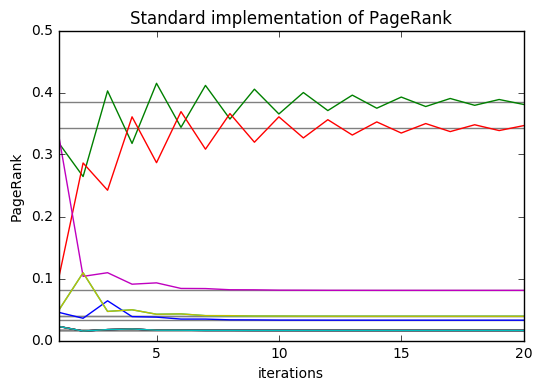

In [86]:
%reload_ext autoreload
%autoreload 2
from ComplexPageRank import ComplexPageRank as PageRank

all_results = []

for iteration in range(1, 21):
    mr_job = PageRank(args=["data/PageRank-test.txt", 
                            "--iterations=%d" % iteration, 
                            "--n_nodes=11",
                            "--damping_factor=.85",
                            "--jobconf=mapred.reduce.tasks=5",
                            "--reduce.tasks=5"])

    results = {}
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            result = mr_job.parse_output_line(line)
            try:
                results[result[0]] = result[1]["PR"]
            except:
                pass
        results["index"] = iteration
    all_results.append(results)
    
data = pd.DataFrame(all_results)
data.index = data.pop("index")
data.plot(kind="line", legend=False)
plt.hlines(true_values,0,iterations-1, colors="grey")
plt.title("Standard implementation of PageRank")
plt.xlabel("iterations")
plt.ylabel("PageRank")
plt.ylim(0,.5)
plt.show()

Notice the oscillations in the scores above. This is likely because there is a feedback loop between the two most highly ranked pages. This oscillation makes sense because B and C are only linked to each other and they both have very high PageRank scores.

In order to fix this and increase the speed of convergence, I added a new PageRank update rule that can be turned on using the `--smart_updating=True` argument. This update rule does the following:  
* Compare the old and new PageRank for a node
* If the percent difference is less than 30%, the actual PageRank value assigned to the node is 75% of the new value plus 25% of the old value.

If there is a big change between the old and new PageRank values (common during the first iterations of the algorithm), the actual PageRank value used is the standard value used. This allows each page to rapidly get to its approximately correct place. 

If there is not a big change, oscillations are removed by smoothing the new PageRank value with the past PageRank value.

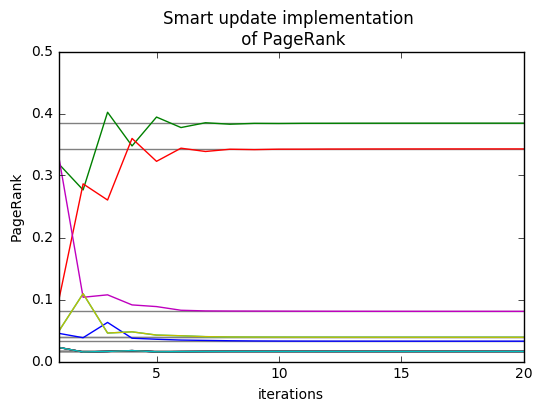

In [88]:
%reload_ext autoreload
%autoreload 2
from ComplexPageRank import ComplexPageRank as PageRank

all_results = []

for iteration in range(1, 21):
    mr_job = PageRank(args=["data/PageRank-test.txt", 
                            "--iterations=%d" % iteration, 
                            "--n_nodes=11",
                            "--damping_factor=.85",
                            "--jobconf=mapred.reduce.tasks=5",
                            "--reduce.tasks=5",
                            "--smart_updating=True"])

    results = {}
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            result = mr_job.parse_output_line(line)
            try:
                results[result[0]] = result[1]["PR"]
            except:
                pass
        results["index"] = iteration
    all_results.append(results)
    
data = pd.DataFrame(all_results)
data.index = data.pop("index")
data.plot(kind="line", legend=False)
plt.hlines(true_values,0,iterations-1, colors="grey")
plt.title("Smart update implementation \n of PageRank")
plt.xlabel("iterations")
plt.ylabel("PageRank")
plt.ylim(0,.5)
plt.show()

The updated algorithm converges much faster on the dataset and the oscillations are removed.

<h2 style="color:darkgreen">  HW 9.1 Analysis </h2>
In the lectures, it was said that a one-stage PageRank algorithm was not possible. This is a working, fully distributed, one-stage PageRank algorithm with a smart updating rule that convergences significantly faster on this dataset.
<br><br>

## 3.  HW9.2: Exploring PageRank teleportation and network plots <a name="1.2"></a>
[Back to Table of Contents](#TOC)


* In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
* Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha, so that each nodes radius is proportional to its PageRank score. 
* In particular you should do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. 
* Note your plots should look like the following: https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

<h2 style="color:darkgreen"> HW 9.2 Implementation </h2>

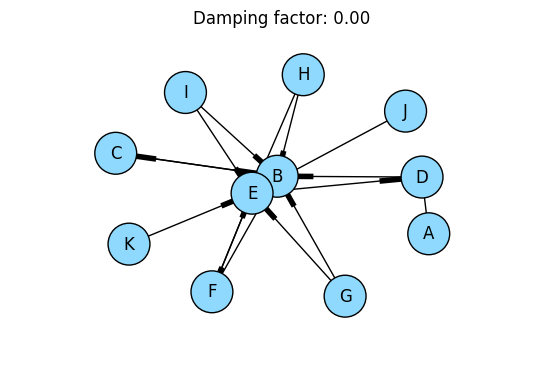

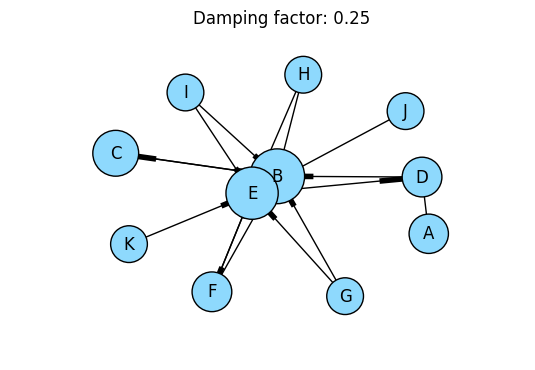

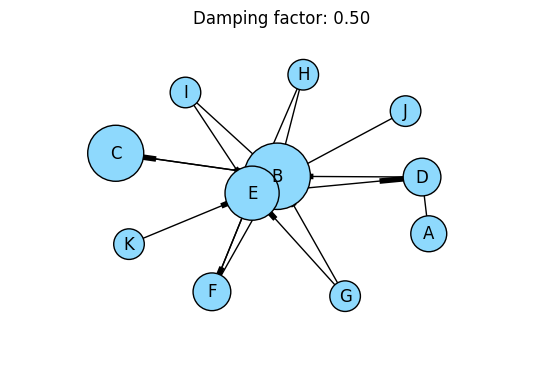

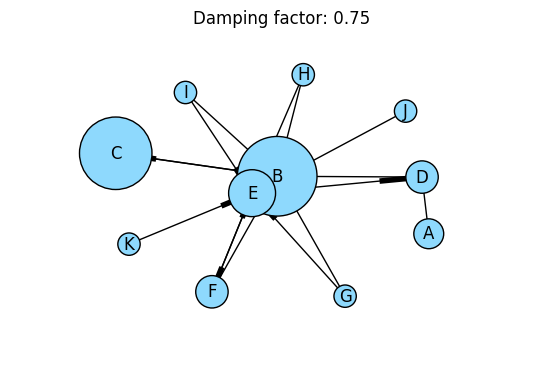

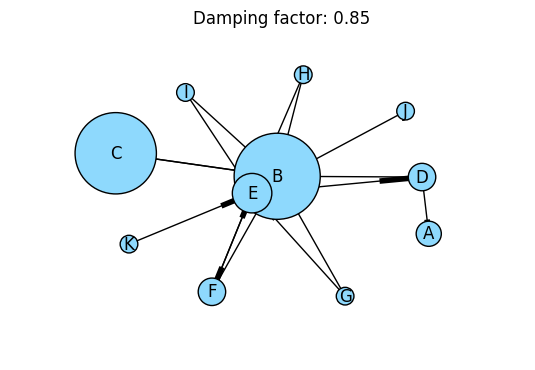

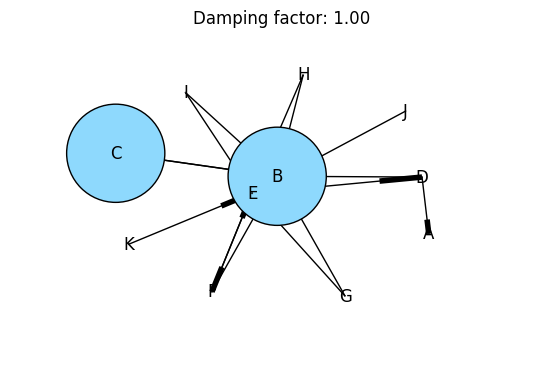

In [164]:
import networkx as nx

def display_graph(edges, PageRanks, title, node_scaling=10000, pos=None):
    DG = nx.DiGraph()
    DG.add_edges_from(edges)
    
    w = []
    for node in DG.nodes():
        weight = PageRanks[node]
        w.append(weight*node_scaling)
        
    nx.draw_networkx(DG, 
                     node_size=w, 
                     node_color="#8ED9FD",
                     pos=pos)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
    
pages = {"B":["C"],
         "C":["B"],
         "D":["A","B"],
         "E":["B","D","F"],
         "F":["B","E"],
         "G":["B","E"],
         "H":["B","E"],
         "I":["B","E"],
         "J":["E"],
         "K":["E"]}

edges = []

for page, links in pages.items():
    for link in links:
        edges.append([page, link])

# Get constant positions
DG = nx.DiGraph()
DG.add_edges_from(edges)
pos = nx.layout.spring_layout(DG)

for damping_factor in [0,0.25,0.5,0.75, 0.85, 1]:
    mr_job = PageRank(args=["data/PageRank-test.txt", 
                            "--iterations=20", 
                            "--n_nodes=11",
                            "--damping_factor=%f" % damping_factor,
                            "--jobconf=mapred.reduce.tasks=5",
                            "--reduce.tasks=5",
                            "--smart_updating=True"])
    results = {}
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            result = mr_job.parse_output_line(line)
            try:
                results[result[0]] = result[1]["PR"]
            except:
                pass
            
    display_graph(edges, results, "Damping factor: %.2f" % damping_factor, pos=pos)

## 3.  HW9.3: Applying PageRank to the Wikipedia hyperlinks network <a name="1.3"></a>
[Back to Table of Contents](#TOC)

* Run your PageRank implementation on the Wikipedia dataset for 5 iterations, and display the top 100 ranked nodes (with alpha = 0.85).
* Run your PageRank implementation on the Wikipedia dataset for 10 iterations, and display the top 100 ranked nodes (with teleportation factor of 0.15).
* Have the top 100 ranked pages changed? Comment on your findings. 
* Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  


<h2 style="color:darkgreen"> HW 9.3 Implementation </h2>

This code is adapted to work on the Wikipedia dataset. There are several modifications to this algorithm:  
* Another step was added to the front that transforms the dataset into the expected format. Specifically, the current format is invalid json and is in a dictionary-type format. We change it into a list format of the links.
* Another step was added to the end to save just the top 100 PageRank values (instead of the full list of 5 million plus values).
* The algorithm was refactored so that the user no longer needs to know the correct number of nodes before running the program (it figures it out as it goes along and appropriately adjusts for dangling nodes as it find them).
* Instead of the sum of all PageRank scores across the network being equal to one, the average of all PageRank scores is now equal to one. This allows us to no longer care about the total PageRank in the entire system. All that matters is that the update rule has an expected value of 1 (which occurs if the damping factor is the same as the damping PageRank contribution to each node. This means a damping factor of .15 should add .15 PR score each iteration to each node.) The results are exactly proportional to the correct Page Rank scores.
* We no longer pass state through the entire system after it is calculated the first time. Instead, we recalculate the number of nodes we have seen each time. This dramatically reduces the complexity of the code, but is an area where the code could be optimized in the future.
* `MRJob.SORT_VALUES = True` was added to the code to ensure that the old keys were sorted from on the reducer. This was needed to get the special keys sorted to the top.

In [217]:
%%writefile SimplePageRank.py
from __future__ import division
import itertools
from mrjob.job import MRJob, MRStep
import json
import heapq


class TopList(list):
    def __init__(self, 
                 max_size, 
                 num_position=0):
        """
        Just like a list, except 
        the append method adds 
        the new value to the 
        list only if it is larger
        than the smallest value 
        (or if the size of 
        the list is less than 
        max_size). 
        
        If each element of the list 
        is an int or float, uses 
        that value for comparison. 
        If the elements in the list 
        are lists or tuples, uses the 
        list_position element of the 
        list or tuple for the 
        comparison.
        """
        self.max_size = max_size
        self.pos = num_position
        
    def _get_key(self, x):
        if isinstance(x, (list, tuple)):
            return x[self.pos]
        else:
            return x
        
    def append(self, val):
        if len(self) < self.max_size:
            heapq.heappush(self, val)
        else:
            lowest_val = self._get_key(self[0])
            current_val = self._get_key(val)
            if current_val > lowest_val:
                heapq.heapreplace(self, val)
                
    def final_sort(self):
        return sorted(self, 
                      key=self._get_key, 
                      reverse=True)
    
    
class SimplePageRank(MRJob):
    MRJob.SORT_VALUES = True
    def configure_options(self):
        super(SimplePageRank, 
              self).configure_options()

        self.add_passthrough_option(
            '--reduce.tasks', 
            dest='reducers', 
            type='int',
            help="""number of reducers
            to use. Controls the hash
            space of the custom
            partitioner""")
        
        self.add_passthrough_option(
            '--iterations', 
            dest='iterations',
            default=5,
            type='int',
            help="""number of iterations
            to perform.""")
        
        self.add_passthrough_option(
            '--damping_factor', 
            dest='d', 
            default=.85,
            type='float',
            help="""Is the damping
            factor. Must be between
            0 and 1.""")
        
        self.add_passthrough_option(
            '--smart_updating', 
            dest='smart_updating', 
            type='str',
            default="False",
            help="""Can be True or
            False. If True, all updates
            to the new PR will take into
            account the value of the old
            PR.""")
        
        self.add_passthrough_option(
            '--return_top_k', 
            dest='return_top_k', 
            type='int',
            default=100,
            help="""Returns the results
            with the top k highest 
            PageRank scores.""")
        
    def clean_data(self, _, lines):
        key, value = lines.split("\t")
        value = json.loads(value.replace("'", '"'))
        links = value.keys()
        values = {"PR":1,"links":links}
        yield (str(key), values)
        
    def mapper_init(self):
        self.values = {"***n_nodes": 0,
                       "**Distribute": 0}
        self.n_reducers = self.options.reducers
    
    def mapper(self, key, line):
        
        n_reducers = self.n_reducers
        key_hash = hash(key)%n_reducers
        
        # Perform a node count each time
        self.values["***n_nodes"] += 1
        PR = line["PR"]
        links = line["links"]
        n_links = len(links)
        
        # If it is not a dangling node
        # distribute its PR to the 
        # other links.
        if n_links:
            PR_to_send = PR/n_links
            for link in links:
                link_hash = hash(link)%n_reducers
                yield (int(link_hash), (link, 
                                   PR_to_send))
        # If it is a dangling node, 
        # distribute its PR to all
        # other links
        else:
            self.values["**Distribute"] += PR
            
        # Pass original node onward
        yield (int(key_hash), (key, line))

    def mapper_final(self):
        # Push special keys to each unique hash
        for key, value in self.values.items():
            for k in range(self.n_reducers):
                yield (int(k), (key, value))
                
            
    def reducer_init(self):
        self.d = self.options.d
        smart = self.options.smart_updating
        if smart == "True":
            self.smart = True
        elif smart == "False":
            self.smart = False
        else:
            msg = """--smart_updating should 
                       be True or False"""
            raise Exception(msg)
        self.to_distribute = None
        self.n_nodes = None

    def reducer(self, hash_key, combo_values):
        gen_values = itertools.groupby(combo_values, 
                                       key=lambda x:x[0])
        # Hask key is a pseudo partitioner.
        # Unpack old keys as separate
        # generators.
        for key, values in gen_values:
            total = 0
            node_info = None

            for key, val in values:
                # If the val is a number,
                # accumulate total.
                if isinstance(val, (float, int)):
                    total += val
                else:
                    # Means that the key-value
                    # pair corresponds to a node
                    # of the form. 
                    # {"PR": ..., "links: [...]}
                    node_info = val
            # Most keys will reference a node, so
            # put this check first.
            if node_info:
                old_pr = node_info["PR"]
                distribute = self.to_distribute or 0
                pr = total + distribute
                decayed_pr = self.d * pr
                teleport_pr = 1-self.d
                new_pr = decayed_pr + teleport_pr
                if self.smart:
                    # Use old PR to inform
                    # new PR.
                    diff = abs(new_pr - old_pr)
                    percent_diff = diff/old_pr
                    if percent_diff < .3:
                        new_pr = .8*new_pr + .2*old_pr
                node_info["PR"] = new_pr
                yield (key, node_info)
            elif key == "***n_nodes":
                self.n_nodes = total
            elif key == "**Distribute":
                self.to_distribute = total/self.n_nodes
            else:
                # Track dangling nodes.
                yield (key, {"PR": 1, 
                             "links": []})
                
    def decrease_file_size(self, key, value):
        val = value["PR"]
        if val > .1:
            yield ("top", (key, round(val,4)))
    
    def collect_init(self):
        top_k = self.options.return_top_k
        self.top_vals = TopList(top_k, 1)
    
    def collect(self, key, values):
        for val in values:
            self.top_vals.append(val)
            
    def collect_final(self):
        for val in self.top_vals.final_sort():
            yield val

    def steps(self):
        iterations = self.options.iterations
        mr_steps = (
            [MRStep(mapper=self.clean_data)] 
            +
            [MRStep(
                   mapper_init=self.mapper_init,
                   mapper=self.mapper,
                   mapper_final=self.mapper_final,
                   reducer_init=self.reducer_init,
                   reducer=self.reducer
                    )]*iterations
            +
            [MRStep(mapper=self.decrease_file_size,
                    reducer_init=self.collect_init,
                    reducer=self.collect,
                    reducer_final=self.collect_final)]
                    )
        return mr_steps


if __name__ == "__main__":
    SimplePageRank.run()

Overwriting SimplePageRank.py


Before running the code on the Wikipedia dataset, we can test it out on a known dataset that is formatted like the Wikipedia dataset. 

In [275]:
!head data/PageRank-test-original.txt

B	{'C': 1}
C	{'B': 1}
D	{'A': 1, 'B': 1}
E	{'D': 1, 'B': 1, 'F': 1}
F	{'B': 1, 'E': 1}
G	{'B': 1, 'E': 1}
H	{'B': 1, 'E': 1}
I	{'B': 1, 'E': 1}
J	{'E': 1}
K	{'E': 1}


In [293]:
%reload_ext autoreload
%autoreload 2
from SimplePageRank import SimplePageRank as PageRank

mr_job = PageRank(args=["data/PageRank-test-original.txt", 
                        "--iterations=50",
                        "--damping_factor=.85",
                        "-q",
                        "--return_top_k=100",
                        "--reduce.tasks=5"])
results = []

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        result = mr_job.parse_output_line(line)
        results.append(result)

print("Actual results:")
pprint(results)
print()

print("Scaled to original:")
total = sum([val for _, val in results])
pprint({key: round(val/total,5) for key, val in results})

Actual results:
[(u'B', 4.2279),
 (u'C', 3.7723),
 (u'E', 0.8897),
 (u'D', 0.43),
 (u'F', 0.43),
 (u'A', 0.3606),
 (u'G', 0.1779),
 (u'H', 0.1779),
 (u'I', 0.1779),
 (u'J', 0.1779),
 (u'K', 0.1779)]

Scaled to original:
{u'A': 0.03278,
 u'B': 0.38435,
 u'C': 0.34294,
 u'D': 0.03909,
 u'E': 0.08088,
 u'F': 0.03909,
 u'G': 0.01617,
 u'H': 0.01617,
 u'I': 0.01617,
 u'J': 0.01617,
 u'K': 0.01617}


From above, we confirm that the algorithm works as expected and that the results can be scaled exactly to the actual PageRank scores.

With smart updating turned on, we see that the results converge very rapidly.

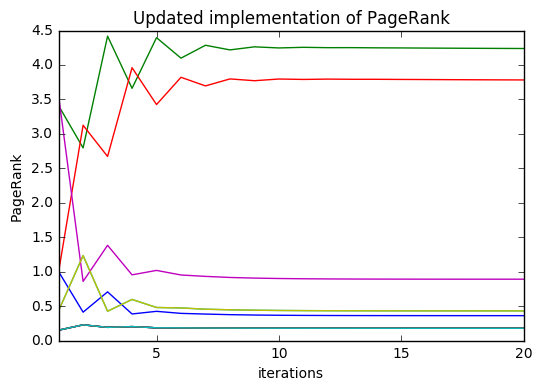

In [294]:
%reload_ext autoreload
%autoreload 2
from SimplePageRank import SimplePageRank as PageRank
import mrjob

all_results = []

for iteration in range(1, 21):
    mr_job = PageRank(args=["data/PageRank-test-original.txt", 
                            "--iterations=%d" % iteration, 
                            "--damping_factor=.85",
                            "--jobconf=mapred.reduce.tasks=5",
                            "--reduce.tasks=5",
                            "--smart_updating=True"])

    results = {}
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            result = mr_job.parse_output_line(line)
            try:
                results[result[0]] = result[1]
            except:
                pass
        results["index"] = iteration
    all_results.append(results)
    
data = pd.DataFrame(all_results)
data.index = data.pop("index")
data.plot(kind="line", legend=False)
plt.title("Updated implementation of PageRank")
plt.xlabel("iterations")
plt.ylabel("PageRank")
plt.show()

Spin up a persistent cluster to assist with quick iteration. The spot price was \$0.04/hour/core. I chose to use 20 cores, so the actual price was \$0.80/hr. Five iterations took 17 minutes and ten iterations took 41 minutes. Back to back, this cost under a dollar in the ideal case. In reality, I tested out many different settings and spent about \$25 total.

In [273]:
!mrjob create-cluster --max-hours-idle=1 \
                      --master-instance-type=m3.xlarge \
                      --instance-type=m3.xlarge \
                      --core-instance-bid-price=0.1 \
                      --num-core-instances=20

Using configs in /Users/BlueOwl1/.mrjob.conf
Using s3://mrjob-3d3e189cec521ef3/tmp/ as our temp dir on S3
Creating persistent cluster to run several jobs in...
Creating temp directory /var/folders/sz/4k2bbjts7x5fmg9sn7kh6hlw0000gn/T/no_script.Jason.20161121.035849.763718
Copying local files to s3://mrjob-3d3e189cec521ef3/tmp/no_script.Jason.20161121.035849.763718/files/...
j-2K0NMAGFV6HVH


The five iteration solution (no smart updating)

In [ ]:
!python SimplePageRank.py -r emr --cluster-id j-2K0NMAGFV6HVH \
                                 --iterations=5 \
                                 -q \
                                 --damping_factor=.85 \
                                 --reduce.tasks=500 \
                                 --output-dir=s3://wiki-temp-data/wiki_out10/ \
                                 --no-output \
                                 s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt

The ten iteration solution (no smart updating)

In [99]:
%%time
!python SimplePageRank.py -r emr --cluster-id j-2K0NMAGFV6HVH \
                                 --iterations=10 \
                                 -q \
                                 --damping_factor=.85 \
                                 --reduce.tasks=500 \
                                 --output-dir=s3://wiki-temp-data/wiki_out12/ \
                                 --no-output \
                                 s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt

CPU times: user 28.5 s, sys: 7.54 s, total: 36 s
Wall time: 41min 5s


The five iteration solution with smart updating.

In [274]:
!python SimplePageRank.py -r emr --cluster-id j-2K0NMAGFV6HVH \
                                 --iterations=5 \
                                 --smart_updating=True \
                                 -q \
                                 --damping_factor=.85 \
                                 --reduce.tasks=500 \
                                 --output-dir=s3://wiki-temp-data/wiki_out12/ \
                                 --no-output \
                                 s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt

Rather than do a fancy distributed join, the indices dataset was small enough to easily read into memory and join it against the data locally.

CPU times: user 1min 7s, sys: 3.95 s, total: 1min 11s
Wall time: 1min 11s


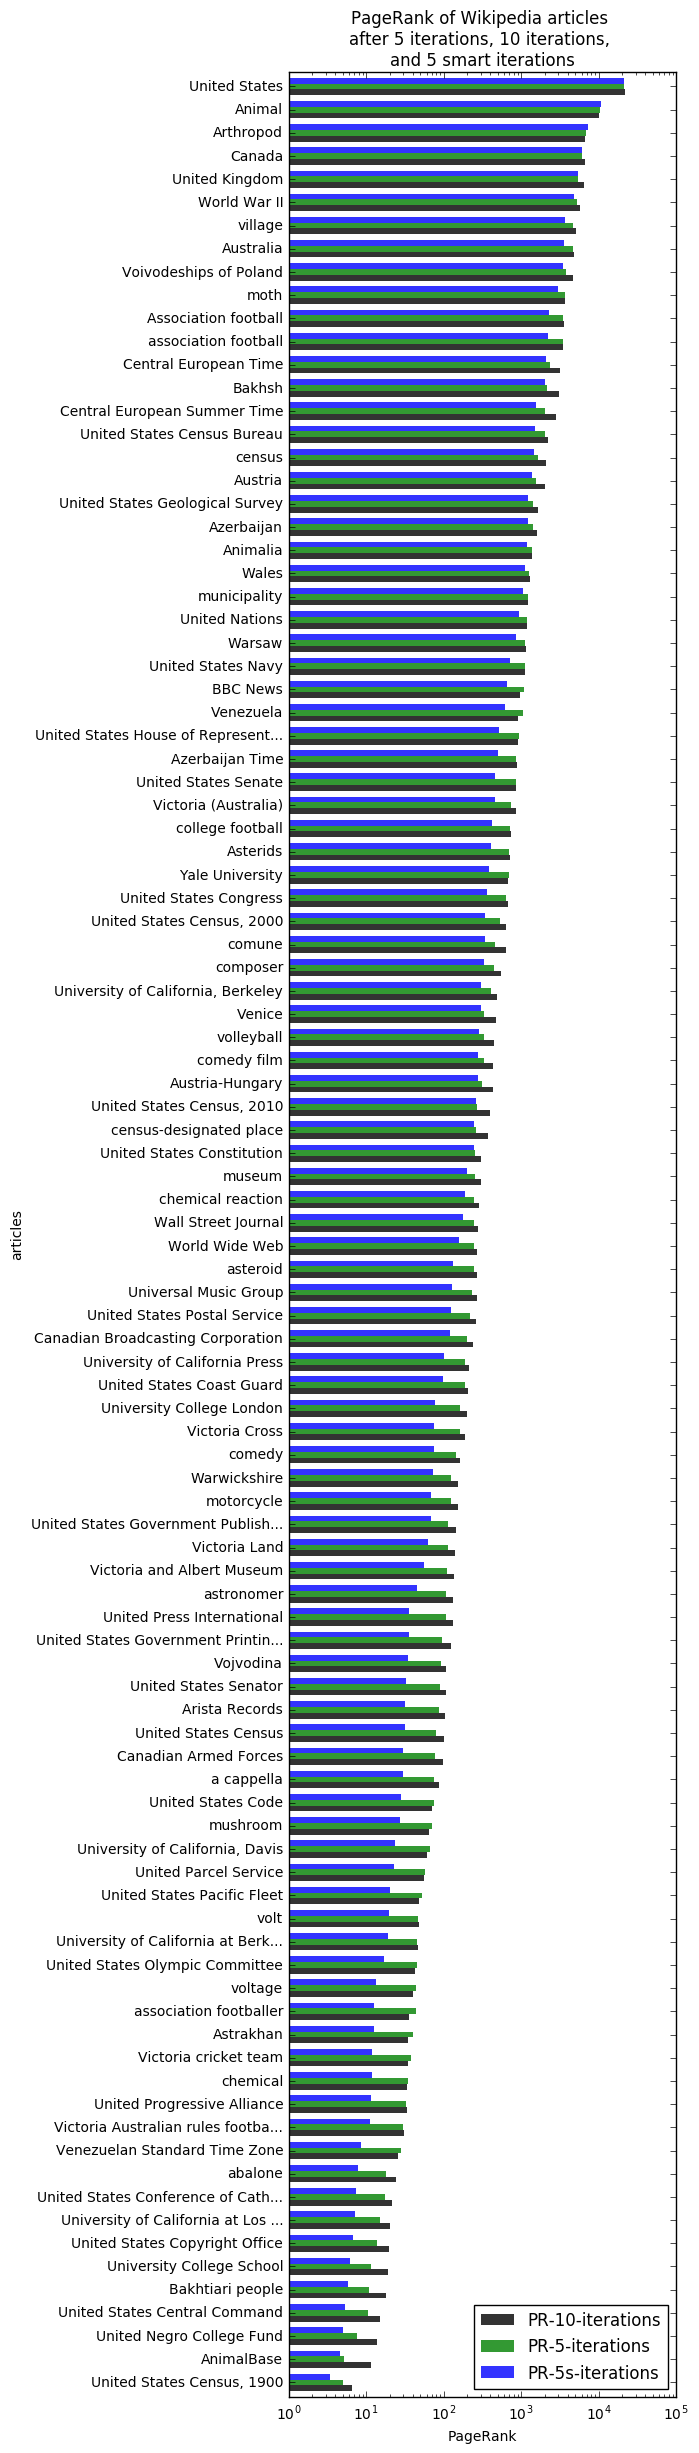

In [302]:
%%time
labels = {}

with open("Temp_data/indices.txt") as label_data:
    for line in label_data:
        data = line.strip().split("\t")
        text = data[0]
        if len(text) > 35:
            text = text[:32] + "..."
        position = int(data[1])
        labels[position] = text
        
file_name = "results/05-iterations.txt"
data5 = pd.read_csv(file_name, sep="\t", header=None, names=["nodes", "PR-5-iterations"])
data5["articles"] = data5.nodes.map(labels)

file_name = "results/10-iterations.txt"
data10 = pd.read_csv(file_name, sep="\t", header=None, names=["nodes", "PR-10-iterations"])
data10["articles"] = data10.nodes.map(labels)

file_name = "results/05-smart-iterations.txt"
data5s = pd.read_csv(file_name, sep="\t", header=None, names=["nodes", "PR-5s-iterations"])
data5s["articles"] = data5s.nodes.map(labels)

new_data = data10.copy()
new_data["PR-5-iterations"] = data5["PR-5-iterations"]
new_data["PR-5s-iterations"] = data5s["PR-5s-iterations"]
new_data.pop("nodes")
new_data.index = new_data.pop("articles")
new_data.sort_values("PR-5-iterations", inplace=True)
new_data.plot(kind="barh", log=True, figsize=(5,30), color=("k","g", "b"), linewidth=0, alpha=.8, width=.75)
plt.title("PageRank of Wikipedia articles \nafter 5 iterations, 10 iterations, \nand 5 smart iterations")
plt.xlabel("PageRank");

We find that the standard 10 iteration solution results in pages with the highest PageRank scores. It is difficult to compare this to the smart updating system. One possibility is that the smart system is more careful when updating values. Indeed, these top values went from having a PageRank score of 1 to a PageRank score of 20,000 in only five iterations! 

I wish to pursue this further, but waiting an hour for the job to run is simply too long. I applied to Amazon for an increase in the limit of spot instances from 20 to 500. At \$0.04/hour/node that means this cluster would cost \$20/hr, but then 10 iterations should take about 2 minutes to run.

## 3.  HW9.4: Topic-specific PageRank implementation using MRJob <a name="1.4"></a>
[Back to Table of Contents](#TOC)

Modify your PageRank implementation to produce a topic specific PageRank implementation, as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.   
This caveat lies in footnote 3 on page 3:
```
	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.
```
and must be adhered to for convergence to be guaranteed.   

Run topic specific PageRank on the following randomly generated network of 100 nodes:

> s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)

which are organized into ten topics, as described in the file:

> s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)

Since there are 10 topics, your result should be 11 PageRank vectors (one for the vanilla PageRank implementation in 9.1, and one for each topic with the topic specific implementation). Print out the top ten ranking nodes and their topics for each of the 11 versions, and comment on your result. Assume a teleportation factor of 0.15 in all your analyses.

One final and important comment here:  please consider the requirements for irreducibility with topic-specific PageRank. In particular, the literature ensures irreducibility by requiring that nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed separately for each of the (10) topics.

So, instead of using this method for irreducibility, please comment on why the literature's method is difficult to implement, and what what extra computation it will require.   

Then for your code, please use the alternative, non-uniform damping vector:

```
vji = beta*(1/|Tj|); if node i lies in topic Tj

vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj
```
for beta in (0,1) close to 1. 

With this approach, you will not have to delete any nodes. If beta > 0.5, PageRank is topic-sensitive, and if beta < 0.5, the PageRank is anti-topic-sensitive. For any value of beta irreducibility should hold, so please try beta=0.99, and perhaps some other values locally, on the smaller networks.

<h2 style="color:darkgreen"> HW 9.4 Implementation </h2>

The literature's method is difficult to implement because it would require n_topics times more computation. Also for each job, you would have to perform this difficult "reachability" calculation. Such a calculation is not trivial because it requires one to determine which nodes are reachable by the topic nodes. 

In [369]:
%%writefile TopicPageRank.py
from __future__ import division
import itertools
from mrjob.job import MRJob, MRStep
import json
from collections import defaultdict, Counter
import heapq


class TopList(list):
    def __init__(self, 
                 max_size, 
                 num_position=0):
        """
        Just like a list, except 
        the append method adds 
        the new value to the 
        list only if it is larger
        than the smallest value 
        (or if the size of 
        the list is less than 
        max_size). 
        
        If each element of the list 
        is an int or float, uses 
        that value for comparison. 
        If the elements in the list 
        are lists or tuples, uses the 
        list_position element of the 
        list or tuple for the 
        comparison.
        """
        self.max_size = max_size
        self.pos = num_position
        
    def _get_key(self, x):
        if isinstance(x, (list, tuple)):
            return x[self.pos]
        else:
            return x
        
    def append(self, val):
        if len(self) < self.max_size:
            heapq.heappush(self, val)
        else:
            lowest_val = self._get_key(self[0])
            current_val = self._get_key(val)
            if current_val > lowest_val:
                heapq.heapreplace(self, val)
                
    def final_sort(self):
        return sorted(self, 
                      key=self._get_key, 
                      reverse=True)
    
    
class TopicPageRank(MRJob):
    MRJob.SORT_VALUES = True
    def configure_options(self):
        super(TopicPageRank, 
              self).configure_options()

        self.add_passthrough_option(
            '--reduce.tasks', 
            dest='reducers', 
            type='int',
            help="""number of reducers
            to use. Controls the hash
            space of the custom
            partitioner""")
        
        self.add_passthrough_option(
            '--iterations', 
            dest='iterations',
            default=5,
            type='int',
            help="""number of iterations
            to perform.""")
        
        self.add_passthrough_option(
            '--damping_factor', 
            dest='d', 
            default=.85,
            type='float',
            help="""Is the damping
            factor. Must be between
            0 and 1.""")
        
        self.add_passthrough_option(
            '--smart_updating', 
            dest='smart_updating', 
            type='str',
            default="False",
            help="""Can be True or
            False. If True, all updates
            to the new PR will take into
            account the value of the old
            PR.""")
        
        self.add_passthrough_option(
            '--return_top_k', 
            dest='return_top_k', 
            type='int',
            default=100,
            help="""Returns the results
            with the top k highest 
            PageRank scores.""")
        
    def clean_init(self):
        # Lazy mode
        self.topic_map = {'24': '9', '25': '7', '26': '1', '27': '1', '20': '3', '21': '9', '22': '4', '23': '6', '28': '7', '29': '1', '4': '5', '8': '8', '59': '2', '58': '2', '55': '7', '54': '8', '57': '9', '56': '6', '51': '5', '50': '7', '53': '7', '52': '1', '88': '5', '89': '4', '82': '2', '83': '4', '80': '5', '81': '1', '86': '3', '87': '8', '84': '4', '85': '7', '3': '10', '7': '10', '100': '8', '39': '8', '38': '4', '33': '1', '32': '1', '31': '3', '30': '7', '37': '6', '36': '1', '35': '7', '34': '5', '60': '10', '61': '8', '62': '8', '63': '4', '64': '10', '65': '4', '66': '3', '67': '1', '68': '10', '69': '6', '2': '3', '6': '8', '99': '5', '98': '1', '91': '3', '90': '5', '93': '4', '92': '1', '95': '10', '94': '9', '97': '7', '96': '9', '11': '6', '10': '1', '13': '6', '12': '2', '15': '3', '14': '9', '17': '10', '16': '1', '19': '1', '18': '8', '48': '10', '49': '10', '46': '1', '47': '7', '44': '1', '45': '5', '42': '9', '43': '10', '40': '3', '41': '4', '1': '10', '5': '5', '9': '2', '77': '1', '76': '4', '75': '2', '74': '10', '73': '2', '72': '4', '71': '2', '70': '3', '79': '4', '78': '4'}
        
    def clean_data(self, _, lines):
        key, value = lines.split("\t")
        value = json.loads(value.replace("'", '"'))
        links = value.keys()
        values = {"PR":1,"links":links,"topic":self.topic_map[str(key)]}
        yield (str(key), values)
        
    def mapper_init(self):
        self.values = {"***n_nodes_topics": defaultdict(int),
                       "**Distribute_topics": defaultdict(int)}
        self.n_reducers = self.options.reducers
    
    def mapper(self, key, line):
        n_reducers = self.n_reducers
        key_hash = hash(key)%n_reducers
        
        # Perform a node count each time
        PR = line["PR"]
        links = line["links"]
        topic = line["topic"]
        n_links = len(links)
        
        # If it is not a dangling node
        # distribute its PR to the 
        # other links.
        if n_links:
            PR_to_send = PR/n_links
            for link in links:
                link_hash = hash(link)%n_reducers
                yield (int(link_hash), (link, 
                                   PR_to_send))
        # If it is a dangling node, 
        # distribute its PR to all
        # other links
        else:
            self.values["**Distribute_topics"][topic] += PR
            
        # Pass original node onward
        yield (int(key_hash), (key, line))

    def mapper_final(self):
        # Push special keys to each unique hash
        for key, value in self.values.items():
            for k in range(self.n_reducers):
                yield (int(k), (key, value))
                
            
    def reducer_init(self):
        # Lazy mode
        self.topic_map = {'24': '9', '25': '7', '26': '1', '27': '1', '20': '3', '21': '9', '22': '4', '23': '6', '28': '7', '29': '1', '4': '5', '8': '8', '59': '2', '58': '2', '55': '7', '54': '8', '57': '9', '56': '6', '51': '5', '50': '7', '53': '7', '52': '1', '88': '5', '89': '4', '82': '2', '83': '4', '80': '5', '81': '1', '86': '3', '87': '8', '84': '4', '85': '7', '3': '10', '7': '10', '100': '8', '39': '8', '38': '4', '33': '1', '32': '1', '31': '3', '30': '7', '37': '6', '36': '1', '35': '7', '34': '5', '60': '10', '61': '8', '62': '8', '63': '4', '64': '10', '65': '4', '66': '3', '67': '1', '68': '10', '69': '6', '2': '3', '6': '8', '99': '5', '98': '1', '91': '3', '90': '5', '93': '4', '92': '1', '95': '10', '94': '9', '97': '7', '96': '9', '11': '6', '10': '1', '13': '6', '12': '2', '15': '3', '14': '9', '17': '10', '16': '1', '19': '1', '18': '8', '48': '10', '49': '10', '46': '1', '47': '7', '44': '1', '45': '5', '42': '9', '43': '10', '40': '3', '41': '4', '1': '10', '5': '5', '9': '2', '77': '1', '76': '4', '75': '2', '74': '10', '73': '2', '72': '4', '71': '2', '70': '3', '79': '4', '78': '4'}
        self.d = self.options.d
        smart = self.options.smart_updating
        if smart == "True":
            self.smart = True
        elif smart == "False":
            self.smart = False
        else:
            msg = """--smart_updating should 
                       be True or False"""
            raise Exception(msg)
        self.to_distribute_topics = Counter()
        self.n_nodes_topics = Counter()

    def reducer(self, hash_key, combo_values):
        gen_values = itertools.groupby(combo_values, 
                                       key=lambda x:x[0])
        # Hask key is a pseudo partitioner.
        # Unpack old keys as separate
        # generators.
        for key, values in gen_values:
            total = 0
            node_info = None

            for key, val in values:
                # If the val is a number,
                # accumulate total.
                if isinstance(val, (float, int)):
                    total += val
                elif isinstance(val, defaultdict):
                    if key == "**Distribute_topics":
                        for k in val:
                            val[k] = val[k]/self.n_nodes_topics[k]
                        self.to_distribute_topics += Counter(val)
                    elif key == "***n_nodes_topics":
                        self.n_nodes_topics += Counter(val)
                else:
                    if key == "**Distribute_topics":
                        continue
                    # Means that the key-value
                    # pair corresponds to a node
                    # of the form. 
                    # {"PR": ..., "links: [...]}
                    node_info = val
            # Most keys will reference a node, so
            # put this check first.
            if node_info:
                old_pr = node_info["PR"]
                distribute = self.to_distribute_topics.get(node_info["topic"]) or 0
                pr = total + distribute
                decayed_pr = self.d * pr
                teleport_pr = 1-self.d
                new_pr = decayed_pr + teleport_pr
                if self.smart:
                    # Use old PR to inform
                    # new PR.
                    diff = abs(new_pr - old_pr)
                    percent_diff = diff/old_pr
                    if percent_diff < .3:
                        new_pr = .8*new_pr + .2*old_pr
                node_info["PR"] = new_pr
                yield (key, node_info)
            else:
                if key in ["***n_nodes_topics", "**Distribute_topics"]:
                    continue
                # Track dangling nodes.
                yield (key, {"PR": 1, 
                             "links": [],
                             "topic": self.topic_map[key]})
                
    def decrease_file_size(self, key, value):
        val = value["PR"]
        if val > .1:
            yield ("top", (key, round(val,4)))
    
    def collect_init(self):
        top_k = self.options.return_top_k
        self.top_vals = TopList(top_k, 1)
    
    def collect(self, key, values):
        for val in values:
            self.top_vals.append(val)
            
    def collect_final(self):
        for val in self.top_vals.final_sort():
            yield val

    def steps(self):
        iterations = self.options.iterations
        mr_steps = (
            [MRStep(mapper_init=self.clean_init,
                    mapper=self.clean_data)] 
            +
            [MRStep(
                   mapper_init=self.mapper_init,
                   mapper=self.mapper,
                   mapper_final=self.mapper_final,
                   reducer_init=self.reducer_init,
                   reducer=self.reducer
                    )]*iterations
            +
            [MRStep(mapper=self.decrease_file_size,
                    reducer_init=self.collect_init,
                    reducer=self.collect,
                    reducer_final=self.collect_final)]
                    )
        return mr_steps


if __name__ == "__main__":
    TopicPageRank.run()

Overwriting TopicPageRank.py


In [370]:
%reload_ext autoreload
%autoreload 2
from TopicPageRank import TopicPageRank as PageRank

mr_job = PageRank(args=["data/randNet.txt", 
                        "--iterations=10",
                        "--damping_factor=.85",
                        "-q",
                        "--return_top_k=100",
                        "--reduce.tasks=5"])
results = []

with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        result = mr_job.parse_output_line(line)
        results.append(result)

pprint(results)

[(u'15', 1.6356),
 (u'74', 1.5969),
 (u'63', 1.5771),
 (u'100', 1.5377),
 (u'85', 1.5179),
 (u'9', 1.5033),
 (u'58', 1.4828),
 (u'71', 1.4491),
 (u'61', 1.4407),
 (u'52', 1.4311),
 (u'77', 1.3664),
 (u'92', 1.3648),
 (u'32', 1.3308),
 (u'13', 1.3178),
 (u'88', 1.3139),
 (u'70', 1.3069),
 (u'17', 1.3066),
 (u'25', 1.2959),
 (u'90', 1.2862),
 (u'49', 1.2549),
 (u'53', 1.2215),
 (u'39', 1.2077),
 (u'51', 1.1786),
 (u'73', 1.1641),
 (u'45', 1.1598),
 (u'99', 1.1543),
 (u'28', 1.1515),
 (u'35', 1.1501),
 (u'56', 1.14),
 (u'55', 1.1129),
 (u'27', 1.1119),
 (u'10', 1.1115),
 (u'94', 1.1111),
 (u'41', 1.1088),
 (u'95', 1.1075),
 (u'91', 1.1028),
 (u'65', 1.0853),
 (u'86', 1.0703),
 (u'84', 1.0589),
 (u'62', 1.0557),
 (u'46', 1.0535),
 (u'2', 1.0334),
 (u'78', 1.0266),
 (u'97', 1.0192),
 (u'83', 1.0173),
 (u'8', 1.0066),
 (u'43', 1.005),
 (u'14', 0.9858),
 (u'21', 0.973),
 (u'12', 0.9678),
 (u'6', 0.966),
 (u'98', 0.9519),
 (u'42', 0.9389),
 (u'11', 0.9342),
 (u'37', 0.9214),
 (u'68', 0.9214),


I hardcoded the topic mapping as a hack. Instead, I would have joined the two datasets together and performed a similar operation in the clean step.